# `0 - Librerias`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import  classification_report, balanced_accuracy_score, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

import joblib  
import os

# `1 - Carga de datos`

In [2]:
# Especificar la ruta al archivo donde se guardaron las variables
variable_folder = "../features"
variables_filename = os.path.join(variable_folder, "model_df_and_features.pkl")

# Cargar las variables
loaded_variables = joblib.load(variables_filename)

# Asignar las variables a los nombres originales
df_shopping = loaded_variables['df_shopping']
target = loaded_variables['target']
fea_num_model = loaded_variables['fea_num_model']
fea_cat_model = loaded_variables['fea_cat_model']
features_to_drop = loaded_variables['features_to_drop']
X_train = loaded_variables['X_train']
y_train = loaded_variables['y_train']
X_test = loaded_variables['X_test']
y_test = loaded_variables['y_test']


# `2 - Pipeline`

In [3]:
# Transformadores para datos categóricos y numéricos
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

# Preprocesador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ("exclude", "drop", features_to_drop), 
        ("num", num_transformer, fea_num_model),
        ("cat", cat_transformer, fea_cat_model)
    ], remainder='passthrough'
)

# Pipeline sin modelo
pipeline_imb_visualizacion = ImbPipeline(steps=[
    ("preprocessor", preprocessor), 
    ("smote", SMOTE(random_state=42)) 
])

### `2.1 - Ver transformaciones del data set`

In [4]:

X_pipeline, y_pipeline = pipeline_imb_visualizacion.fit_resample(X_train, y_train)

# DataFrame
column_names = pipeline_imb_visualizacion.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)
df_shopping_transformado = pd.DataFrame(X_pipeline, columns=column_names)

df_shopping_transformado

,num__Administrative,num__ProductRelated,num__PageValues,num__ProductRelated_Duration,num__BounceRates,num__ExitRates,cat__Month_Dec,cat__Month_Feb,cat__Month_Jul,cat__Month_June,...,cat__Month_Nov,cat__Month_Oct,cat__Month_Sep,cat__SpecialDay_0.2,cat__SpecialDay_0.4,cat__SpecialDay_0.6,cat__SpecialDay_0.8,cat__SpecialDay_1.0,cat__VisitorType_Other,cat__VisitorType_Returning_Visitor
0,1.450438,0.593733,1.927643,0.592626,-0.285981,-0.826352,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.991485,-1.130270,-0.530566,-0.697177,1.488583,1.562432,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.991485,-1.130270,-0.530566,-1.220568,-0.797632,0.716121,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.562971,-0.003214,1.955261,0.509738,0.297545,0.321795,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.991485,0.540581,1.980610,0.241800,-0.797632,-1.732567,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16671,-0.991485,-1.162172,-0.530566,-1.020514,-0.797632,1.486310,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16672,1.179061,-0.108096,-0.530566,0.949913,0.374801,0.320489,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16673,1.374622,1.971934,1.944968,1.605791,-0.790427,-1.221718,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16674,-0.991485,0.105189,-0.530566,-0.100993,0.984728,0.623353,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
# Se comprueba si SMOTE a funcionado
y_pipeline.value_counts()

Revenue
False    8338
True     8338
Name: count, dtype: int64

# `3 - Modelado`

## `3.1 - Modelos`

In [6]:
models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='aucpr', random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, thread_count=-1),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),  
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'NaiveBayes': GaussianNB(),  
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42, n_iter_no_change=10),  
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

## `3.2 - Aplicación Pipeline + Selección best model`

In [7]:
recall_scores = {}

for model_name, model in models.items():
    pipeline_imb = ImbPipeline(steps=[
    ("preprocessor", preprocessor),                  
    ("smote", SMOTE(random_state=42)), 
    ('classifier', model)
    ])
    
    pipeline_imb.fit(X_train, y_train)
    
    models_pkl_folder = "../model/Base_model/Scoring_recall"
    model_filename = os.path.join(models_pkl_folder, f"{model_name}_base_model.pkl")
    joblib.dump(pipeline_imb, model_filename) 
    print(f"Modelo {model_name} guardado como {model_filename}\n")

    cv_scores = cross_val_score(pipeline_imb, X_train, y_train, cv=5, scoring="recall", error_score="raise")
    mean_score = np.mean(cv_scores)
    recall_scores[model_name] = mean_score
    print(f"Modelo: {model_name}, Recall: {mean_score:.4f}")

Modelo RandomForest guardado como ../model/Base_model/Scoring_recall\RandomForest_base_model.pkl

Modelo: RandomForest, Recall: 0.7490
Modelo XGBoost guardado como ../model/Base_model/Scoring_recall\XGBoost_base_model.pkl

Modelo: XGBoost, Recall: 0.7117
Modelo LightGBM guardado como ../model/Base_model/Scoring_recall\LightGBM_base_model.pkl

Modelo: LightGBM, Recall: 0.7392
Modelo CatBoost guardado como ../model/Base_model/Scoring_recall\CatBoost_base_model.pkl

Modelo: CatBoost, Recall: 0.7248
Modelo LogisticRegression guardado como ../model/Base_model/Scoring_recall\LogisticRegression_base_model.pkl

Modelo: LogisticRegression, Recall: 0.8198
Modelo SVM guardado como ../model/Base_model/Scoring_recall\SVM_base_model.pkl

Modelo: SVM, Recall: 0.8690
Modelo KNN guardado como ../model/Base_model/Scoring_recall\KNN_base_model.pkl

Modelo: KNN, Recall: 0.7988
Modelo NaiveBayes guardado como ../model/Base_model/Scoring_recall\NaiveBayes_base_model.pkl

Modelo: NaiveBayes, Recall: 0.9128
M

In [8]:
df_recall_scores = pd.DataFrame(list(recall_scores.items()), columns=["Modelo", "Recall"])
df_recall_scores = df_recall_scores.sort_values(by="Recall", ascending=False).reset_index(drop=True)
df_recall_scores

,Modelo,Recall
0,NaiveBayes,0.912847
1,SVM,0.868957
2,LogisticRegression,0.819796
3,GradientBoosting,0.813910
4,KNN,0.798843
5,AdaBoost,0.796209
6,RandomForest,0.749022
7,LightGBM,0.739190
8,CatBoost,0.724781
9,XGBoost,0.711670


In [9]:
best_models = list(df_recall_scores[:5]["Modelo"])
best_models

['NaiveBayes', 'SVM', 'LogisticRegression', 'GradientBoosting', 'KNN']

In [10]:
from sklearn import set_config

set_config(display="diagram")

pipeline_imb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('exclude', 'drop',
                                                  ['OperatingSystems', 'Region',
                                                   'Weekend',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'Browser', 'TrafficType']),
                                                 ('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['Administrative',
                                                   'ProductRelated',
                                                   'PageValues',
                                                   'ProductRelated_Duration',
                                                   'BounceRates',
                                                   'ExitRates']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Month', 'SpecialDay',
                                                   'VisitorType'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', AdaBoostClassifier(random_state=42))])

## `3.3 - Grid Search sobre los mejores modelos`

In [11]:
grid_params = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 200],  
        'classifier__learning_rate': [0.01, 0.1, 0.2], 
        'classifier__max_depth': [3, 5, 7],  
        'classifier__scale_pos_weight': [1, 5, 10]
    },
    'NaiveBayes': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]  
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],  
        'classifier__kernel': ['linear', 'rbf'],  
        'classifier__gamma': ['scale', 'auto'] 
    },
    'GradientBoosting': {
        'classifier__n_estimators': [50, 100],  
        'classifier__learning_rate': [0.01, 0.1],  
        'classifier__max_depth': [3, 5]  
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1],  
        'classifier__penalty': ['l2', 'none'],  
        'classifier__solver': ['lbfgs', 'liblinear']  
    },
    'AdaBoost': {
        'classifier__n_estimators': [50, 100],  
        'classifier__learning_rate': [0.01, 0.1, 0.5]  
    }
}


In [12]:
models = {
    'XGBoost': XGBClassifier(eval_metric='aucpr', random_state=42, n_jobs=-1
    ),
    'NaiveBayes': GaussianNB(var_smoothing=1e-9
    ),  
    'SVM': SVC(C=1, kernel='linear', gamma='scale', probability=True, random_state=42
    ),  
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        C=1, penalty='l2', solver='lbfgs', class_weight='balanced', random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42
    )
}

grid_search_results = []

# GridSearch para cada modelo
for model_name, model in models.items():
    pipeline_imb = ImbPipeline(steps=[
    ("preprocessor", preprocessor),                  
    ("smote", SMOTE(random_state=42)), 
    ('classifier', model)
    ])
    

    grid_search = GridSearchCV(
        pipeline_imb, 
        param_grid=grid_params[model_name],
        cv=5, 
        scoring="recall", 
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    grid_search_results.append((model_name, best_model, best_score))
    print(f"Modelo: {model_name}, Mejor Recall en validación: {best_score:.4f}")

    models_pkl_folder = "../model/Best_params_model/Scoring_recall"
    model_filename = os.path.join(models_pkl_folder, f"{model_name}_best_model.pkl")
    joblib.dump(best_model, model_filename) 
    print(f"Modelo {model_name} guardado como {model_filename}\n")

Modelo: XGBoost, Mejor Recall en validación: 1.0000
Modelo XGBoost guardado como ../model/Best_params_model/Scoring_recall\XGBoost_best_model.pkl

Modelo: NaiveBayes, Mejor Recall en validación: 0.9128
Modelo NaiveBayes guardado como ../model/Best_params_model/Scoring_recall\NaiveBayes_best_model.pkl

Modelo: SVM, Mejor Recall en validación: 0.8690
Modelo SVM guardado como ../model/Best_params_model/Scoring_recall\SVM_best_model.pkl

Modelo: GradientBoosting, Mejor Recall en validación: 0.8506
Modelo GradientBoosting guardado como ../model/Best_params_model/Scoring_recall\GradientBoosting_best_model.pkl

Modelo: LogisticRegression, Mejor Recall en validación: 0.8257
Modelo LogisticRegression guardado como ../model/Best_params_model/Scoring_recall\LogisticRegression_best_model.pkl

Modelo: AdaBoost, Mejor Recall en validación: 0.8126
Modelo AdaBoost guardado como ../model/Best_params_model/Scoring_recall\AdaBoost_best_model.pkl



## `3.4 - Scoring de los mejores modelos`

Resultados para el modelo: XGBoost_best_model
Recall en el conjunto de prueba: 0.5000

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2084
        True       0.15      1.00      0.27       382

    accuracy                           0.15      2466
   macro avg       0.08      0.50      0.13      2466
weighted avg       0.02      0.15      0.04      2466

------------------------------------------------------------


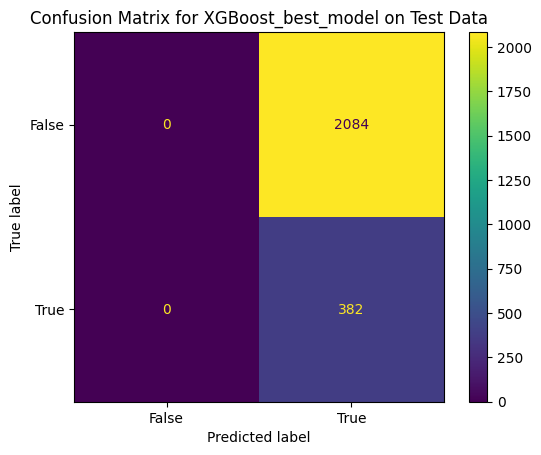

Resultados para el modelo: NaiveBayes_best_model
Recall en el conjunto de prueba: 0.6184

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.94      0.35      0.52      2084
        True       0.20      0.88      0.33       382

    accuracy                           0.44      2466
   macro avg       0.57      0.62      0.42      2466
weighted avg       0.83      0.44      0.49      2466

------------------------------------------------------------


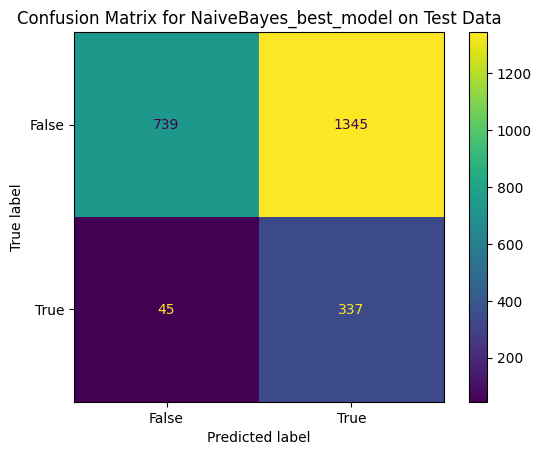

Resultados para el modelo: SVM_best_model
Recall en el conjunto de prueba: 0.8571

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.97      0.85      0.91      2084
        True       0.51      0.86      0.64       382

    accuracy                           0.85      2466
   macro avg       0.74      0.86      0.78      2466
weighted avg       0.90      0.85      0.87      2466

------------------------------------------------------------


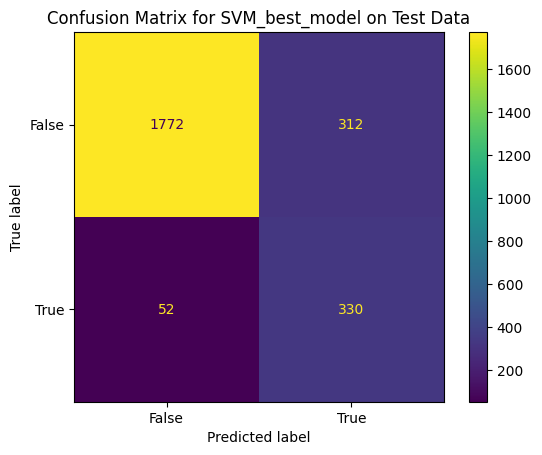

Resultados para el modelo: GradientBoosting_best_model
Recall en el conjunto de prueba: 0.8433

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      2084
        True       0.50      0.84      0.63       382

    accuracy                           0.84      2466
   macro avg       0.73      0.84      0.76      2466
weighted avg       0.89      0.84      0.86      2466

------------------------------------------------------------


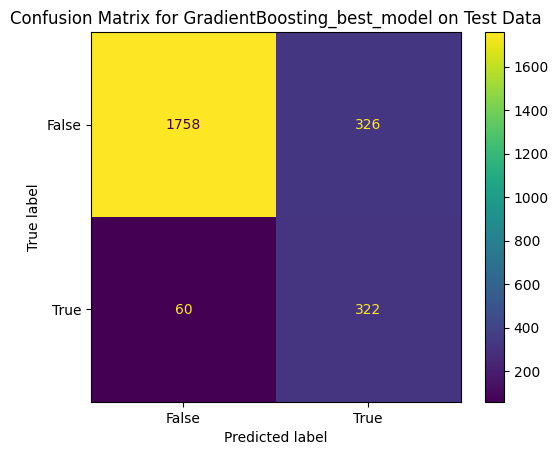

Resultados para el modelo: LogisticRegression_best_model
Recall en el conjunto de prueba: 0.8282

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.96      0.86      0.91      2084
        True       0.52      0.79      0.62       382

    accuracy                           0.85      2466
   macro avg       0.74      0.83      0.77      2466
weighted avg       0.89      0.85      0.86      2466

------------------------------------------------------------


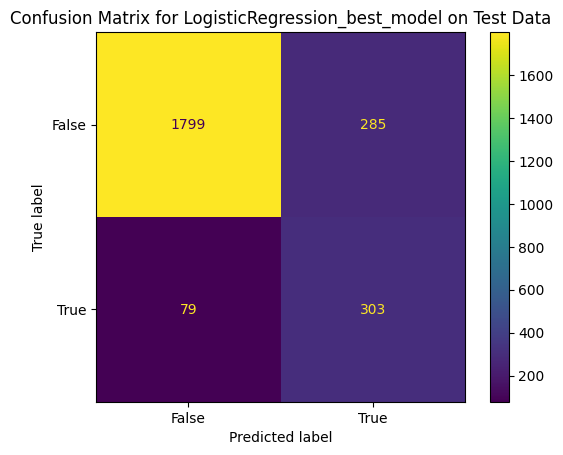

Resultados para el modelo: AdaBoost_best_model
Recall en el conjunto de prueba: 0.8327

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      2084
        True       0.55      0.78      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.78      2466
weighted avg       0.89      0.87      0.88      2466

------------------------------------------------------------


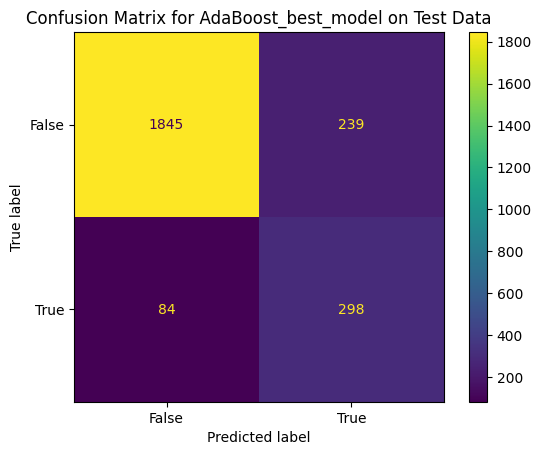

In [13]:
# Modelos
model_names = [f"{model_name}_best_model" for model_name in models.keys()]

# Best params de los modelos
base_path = "../model/Best_params_model/Scoring_recall/"


for model_name in model_names:
    
    model_path = f"{base_path}{model_name}.pkl"
    modelo_entrenado = joblib.load(model_path)
    
    modelo_entrenado.fit(X_train, y_train)
    y_pred = modelo_entrenado.predict(X_test)
    
    # Balanced Accuracy y Classification Report
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    
    print(f"Resultados para el modelo: {model_name}")
    print(f"Recall en el conjunto de prueba: {balanced_acc:.4f}")
    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_rep)
    print("-" * 60)
    
    # Matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix for {model_name} on Test Data")
    plt.show()